#### Acquire Data

In [1]:
import sys
import os
app = os.path.abspath(os.path.join(os.getcwd(), os.pardir,'app'))
sys.path.append(app)
from utils import acquire_data

d = acquire_data(path=r'C:\data')
d.download_flights(url='https://zenodo.org/record/7323875#.Y6GCi3ZBzIU')
d.parse(airports=["LGAV","LGRP","LGSA","LGIR","LGTS","LGKO"])
d.download_covid_feature()
d.covid_feature("LGAV")

Downloaded 0  files.
Selected Feature:people_vaccinated


In [1]:
import pandas as pd
import sys
import os
app = os.path.abspath(os.path.join(os.getcwd(), os.pardir,'app'))
sys.path.append(app)
from utils import flights
import matplotlib.pyplot as plt
plt.style.use('bmh')

data = os.path.abspath(os.path.join(os.getcwd(), os.pardir,'data'))
os.chdir(data)

#Cleaned Data
f = flights('LGAV')
dfs = f.get_dfs()
df = dfs[0]

#Raw Data
raw=pd.read_csv('raw.csv')
raw['day'] = pd.DatetimeIndex(raw['day']).tz_localize(None)
raw.set_index('day',inplace=True)

---
### Exploratory Analysis - Raw 

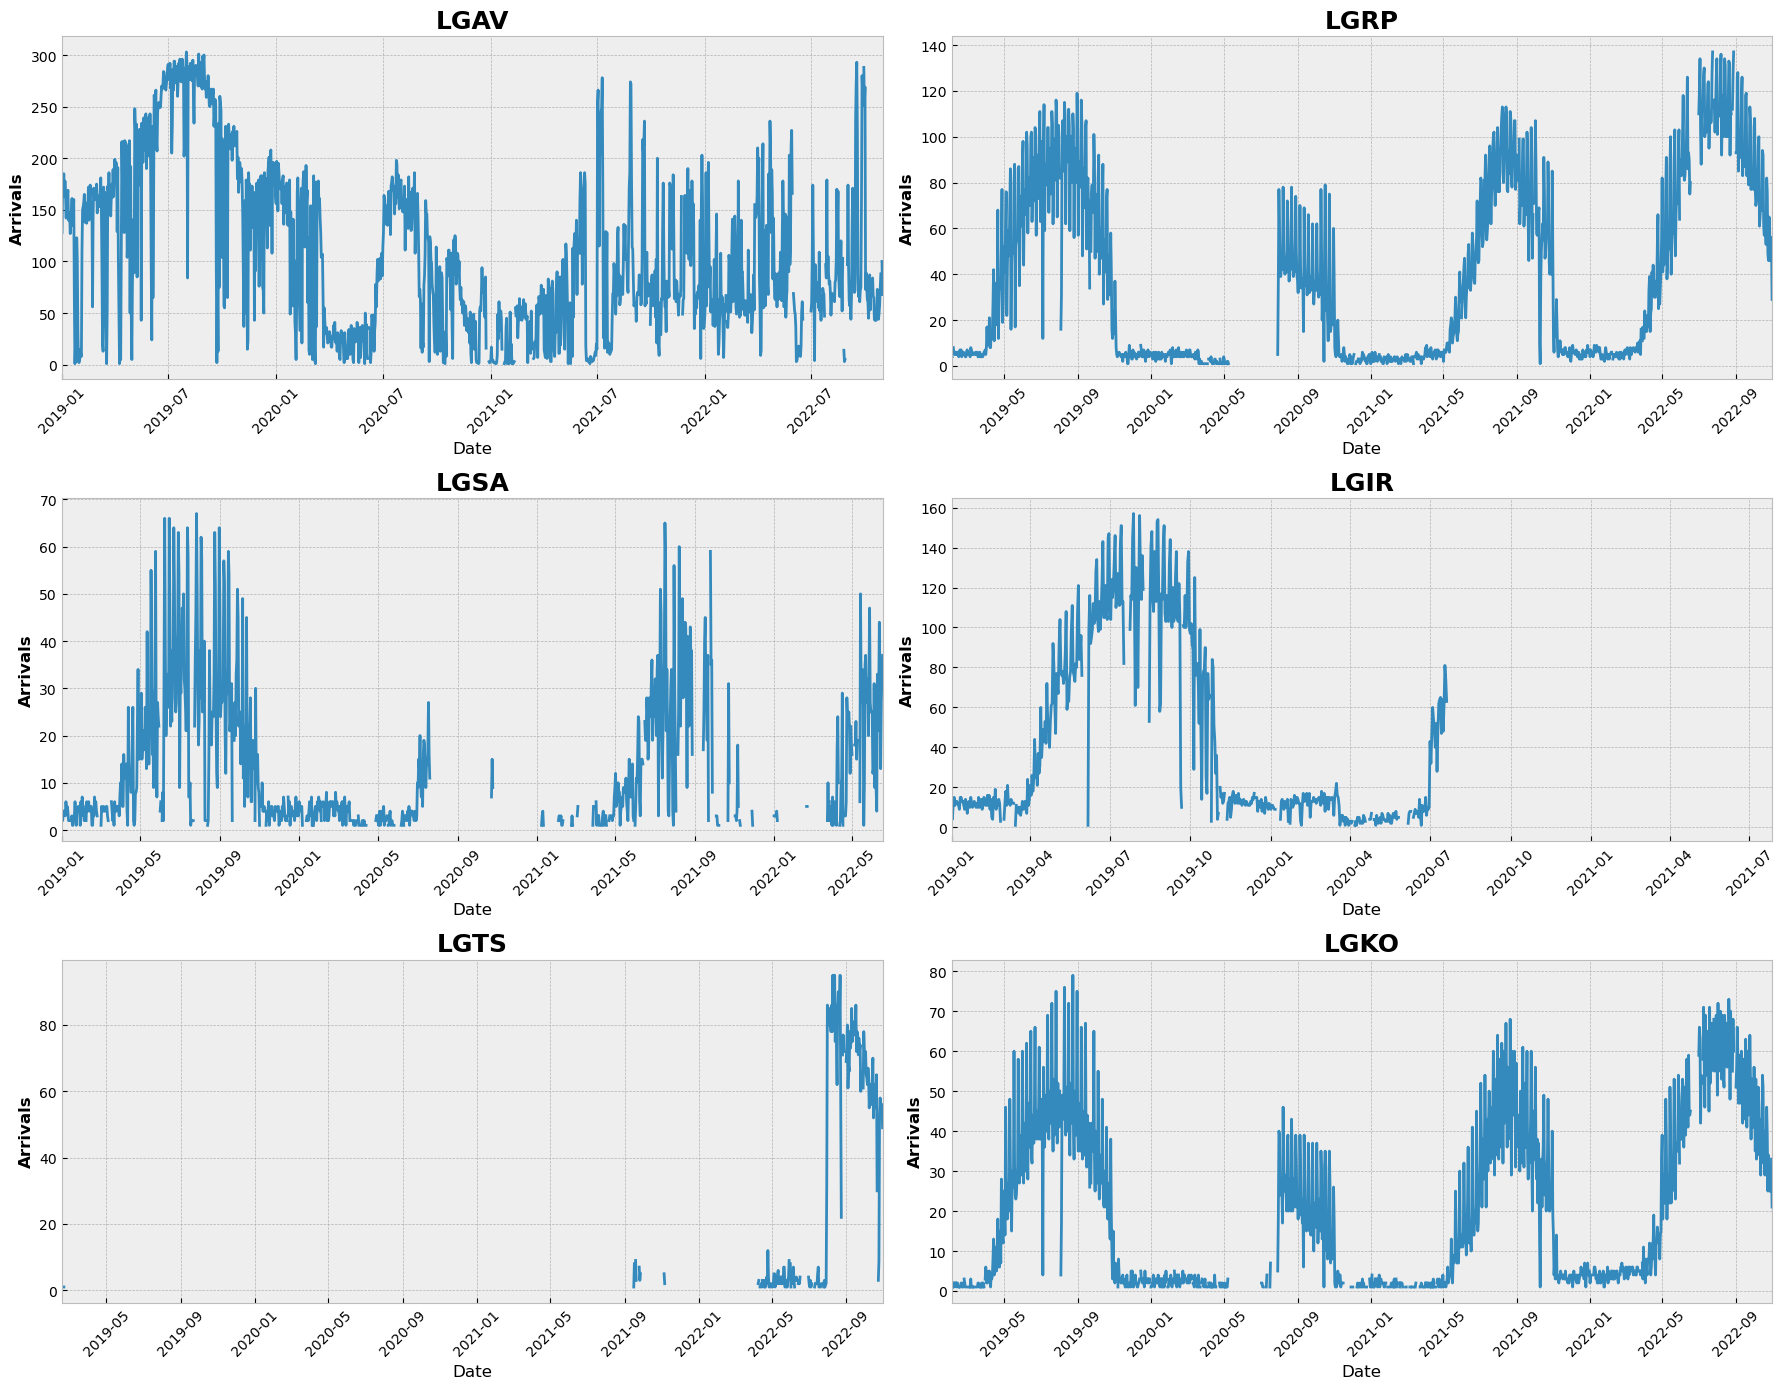

In [3]:
plt.figure(figsize=(18,14))
for i, airport in enumerate(raw.columns):
    ax = plt.subplot(3, 2, i+1)
    ax.plot(raw[airport])
    plt.xticks(rotation=45)
    ax.set_title(airport, fontsize=18, fontweight='bold',c='black')
    plt.xlabel('Date', fontsize=12, c='black')
    plt.ylabel('Arrivals', fontsize=12, fontweight='bold',c='black')
    plt.margins(x=0)
plt.tight_layout()

plt.show()

In [4]:
(raw.isnull().mean() * 100).sort_values().map('{:.2f}%'.format)

LGAV     2.57%
LGRP    11.14%
LGKO    15.00%
LGSA    42.93%
LGIR    63.14%
LGTS    86.93%
dtype: object

In [5]:
(raw.isnull().sum()).sort_values()

LGAV      36
LGRP     156
LGKO     210
LGSA     601
LGIR     884
LGTS    1217
dtype: int64

In [6]:
raw.describe()

,LGAV,LGRP,LGSA,LGIR,LGTS,LGKO
count,1364.00,1244.00,799.00,516.00,183.00,1190.00
mean,108.11,38.17,13.43,41.83,34.37,20.48
std,79.71,38.41,14.61,44.72,35.10,20.47
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,46.00,5.00,3.00,10.00,2.00,2.25
50%,85.00,20.00,6.00,14.50,7.00,12.00
75%,166.00,72.00,22.00,77.25,71.50,37.00
max,303.00,137.00,67.00,157.00,95.00,79.00


---
### Outliers

In [7]:
low1, low2 = {}, {}
for year in raw.index.year.unique().values:
    low1[year]=raw[raw.index.year == year].query('LGAV <10 ').count().values[0]
    low2[year]=raw[raw.index.year == year].query('LGAV <20 ').count().values[0]    
temp = pd.DataFrame([low1,low2],index=['Arrivals LGAV < 10','Arrivals LGAV < 20'])
temp['Total']= temp.sum(axis=1)
temp

,2019,2020,2021,2022,Total
Arrivals LGAV < 10,12,33,56,10,111
Arrivals LGAV < 20,17,61,82,17,177


In [8]:
low1, low2 = {}, {}
for year in df.index.year.unique().values:
    low1[year]=df[df.index.year == year].query('LGAV <10 ').count().values[0]
    low2[year]=df[df.index.year == year].query('LGAV <20 ').count().values[0]    
temp = pd.DataFrame([low1,low2],index=['Arrivals LGAV < 10','Arrivals LGAV < 20'])
temp['Total']= temp.sum(axis=1)
temp

,2019,2020,2021,2022,Total
Arrivals LGAV < 10,0,6,19,1,26
Arrivals LGAV < 20,0,21,40,4,65


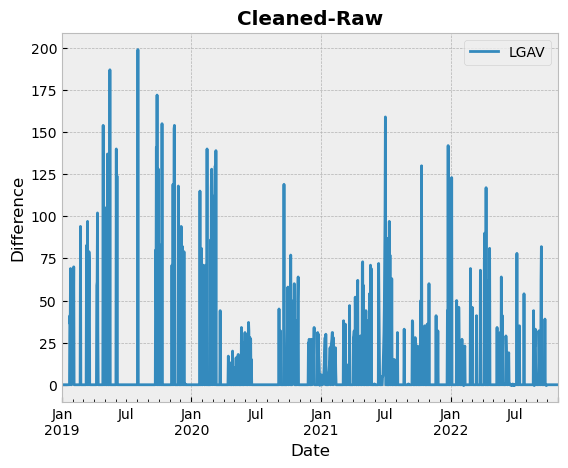

In [9]:
import matplotlib.pyplot as plt
diff = pd.DataFrame(df.LGAV-raw.LGAV.interpolate())
diff.plot()
plt.title('Cleaned-Raw', fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

In [10]:
len(diff.query('LGAV>0'))

270

---
### Exploratory Analysis - Clean

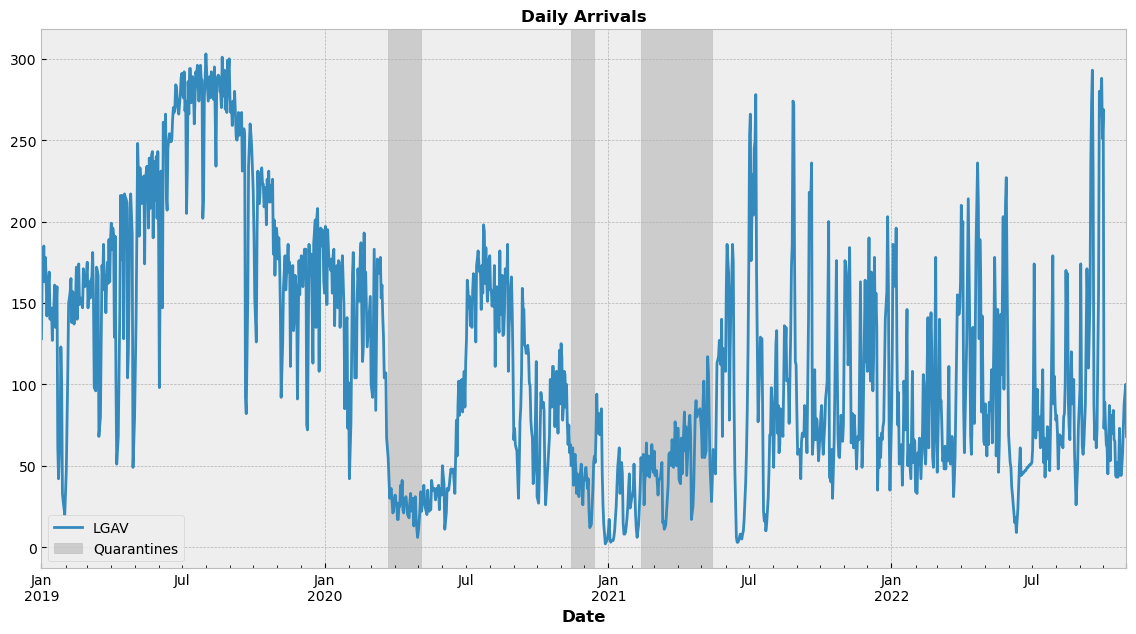

In [11]:
df.plot(kind='line', figsize=(14,7))
plt.title('Daily Arrivals', fontsize=12, fontweight='bold')
plt.xlabel('Date', fontweight='bold')
plt.axvspan('2020-03-23', '2020-05-4', color='gray', alpha=0.3, label='Quarantines')
plt.axvspan('2020-11-14', '2020-12-14', color='gray', alpha=0.3)
plt.axvspan('2021-02-12', '2021-05-14', color='gray', alpha=0.3)
plt.legend(loc=3)
plt.show()

In [12]:
from scipy.stats import kstest
from statsmodels.tsa.stattools import adfuller

norm = pd.DataFrame(kstest(df,'norm'),index=['KstestStatistic','p_value'], columns=['LGAV'])
stat = pd.DataFrame(adfuller(df)[:2],index=['AdFullerStatistic','p_value'], columns=['LGAV'])

pd.concat([df.describe(), norm, stat])

,LGAV
count,1400.00
mean,115.95
std,75.16
min,2.00
25%,55.00
50%,98.00
75%,168.00
max,303.00
KstestStatistic,1.00
p_value,0.00


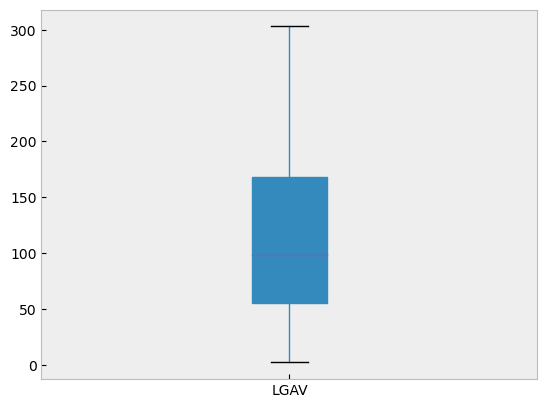

In [13]:
df.boxplot(patch_artist=True)
plt.grid(False)
plt.show()

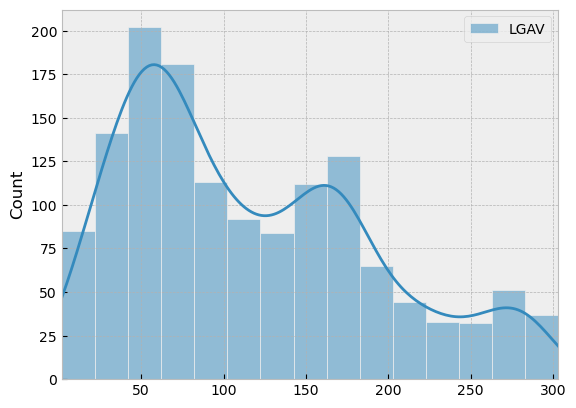

In [14]:
import seaborn as sns
sns.histplot(df, kde=True)
plt.margins(x=0)
plt.show()

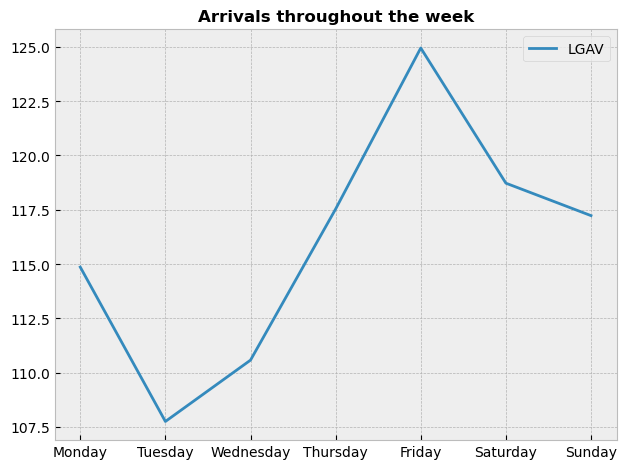

In [15]:
df_year_weekday = df.groupby(df.index.weekday).mean()
ax = df_year_weekday.plot(kind='line')

# Set the x-axis tick labels to the names of the weekdays
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(range(7), weekday_names)
plt.xlabel("")
plt.title("Arrivals throughout the week", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

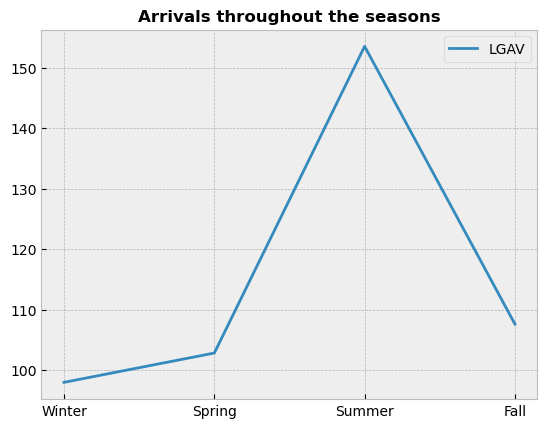

In [16]:
df_year_weekday = df.groupby(df.index.quarter).mean()
ax = df_year_weekday.plot(kind='line')

# Set the x-axis tick labels to the names of the seasons
seasons = ['Winter', 'Spring', 'Summer', 'Fall']
plt.xticks(range(1,5), seasons)
plt.xlabel("")
plt.title("Arrivals throughout the seasons", fontsize=12, fontweight='bold')
plt.show()